# 04. Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [1]:
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/04_metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/04_predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/04_alerts_self_training_sample.csv"

ALERT_FROM_CLASS = "Unhealthy"

In [2]:
# Parameters
SEMI_DATASET_PATH = "data/processed/02_dataset_for_semi.parquet"
CUTOFF = "2017-01-01"
TAU = 0.8
MAX_ITER = 3
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.2
RANDOM_STATE = 42
METRICS_PATH = "data/processed/10_04_metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/10_04_predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/10_04_alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,154115,0.8
1,2,0.708228,0.675047,229847,166298,0.8
2,3,0.701918,0.666222,63549,27129,0.8


Test accuracy: 0.5942055065682923
Test f1_macro: 0.521503620245298


Figure saved to: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\04_self_training_dynamics.png


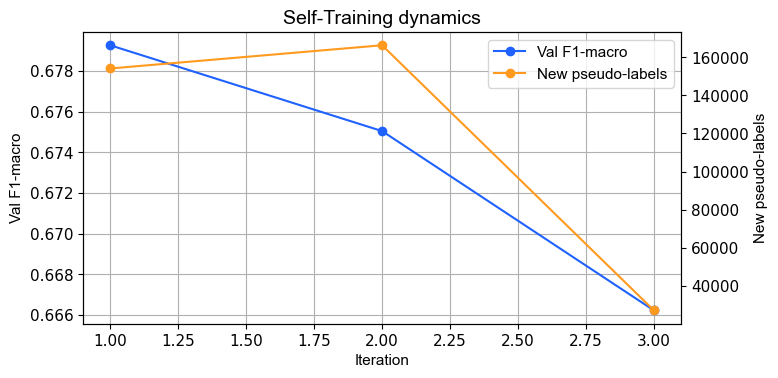

Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\10_04_metrics_self_training.json
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\10_04_predictions_self_training_sample.csv
Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\10_04_alerts_self_training_sample.csv


In [3]:
from pathlib import Path
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Find project root and add to path BEFORE importing from src
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

out = run_self_training(df, data_cfg, st_cfg)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Plot dynamics
fig, ax1 = plt.subplots(figsize=(8, 4))
line1 = ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="#1F62FF", label="Val F1-macro")
ax1.set_xlabel("Iteration", fontsize=11, fontfamily='Arial')
ax1.set_ylabel("Val F1-macro", fontsize=11, fontfamily='Arial')
ax1.tick_params(axis='both', labelsize=11)
ax1.grid(True)

ax2 = ax1.twinx()
line2 = ax2.plot(history["iter"], history["new_pseudo"], marker="o", color="#FF9A1F", label="New pseudo-labels")
ax2.set_ylabel("New pseudo-labels", fontsize=11, fontfamily='Arial')
ax2.tick_params(axis='y', labelsize=11)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', prop={'family': 'Arial', 'size': 11})

plt.title("Self-Training dynamics", fontsize=14, fontfamily='Arial')
plt.tight_layout(pad=1.5)

# Save figure based on instructions
images_dir = PROJECT_ROOT / "images"
images_dir.mkdir(parents=True, exist_ok=True)
fig_path = images_dir / "04_self_training_dynamics.png"
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {fig_path}")

plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()
for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head().to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head().to_csv(alerts_path, index=False)

print("Saved:", metrics_path)
print("Saved:", pred_path)
print("Saved:", alerts_path)